##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 言語理解のためのTransformerモデル

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

このチュートリアルでは、ポルトガル語を英語に翻訳する<a href="https://arxiv.org/abs/1706.03762" class="external">Transformerモデル</a>を訓練します。これは上級編のサンプルで、[テキスト生成](text_generation.ipynb)や[アテンション（注意機構）](nmt_with_attention.ipynb)の知識を前提としています。

Transformerモデルの背後にある中心的なアイデアは*セルフアテンション（自己注意）*、 つまり、シーケンスの表現を計算するために入力シーケンスの異なる位置に注意を払うことができることにあります。

Transformerモデルは、[RNNs](text_classification_rnn.ipynb)や[CNNs](../images/intro_to_cnns.ipynb)の代わりに セルフアテンション・レイヤーを重ねたものを使って、可変長の入力を扱います。この一般的なアーキテクチャにはいくつもの利点があります。

* データの中の時間的／空間的な関係を前提にしません。これは、オブジェクトの集合（例えば、[StarCraftのユニット](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8))を扱うには理想的です。
* レイヤーの出力はRNNのような系列ではなく、並列に計算可能です。
* たくさんのRNNのステップや畳み込み層を経ることなく、離れた要素どうしが互いの出力に影響を与えることができます（例えば、[Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf)を参照)。
* 長距離の依存関係を学習可能です。これは、シーケンスを扱うタスクにおいては難しいことです。

このアーキテクチャの欠点は次のようなものです。

* 時系列では、あるタイムステップの出力が、入力とその時の隠れ状態だけからではなく、*過去全て*から計算されます。
* テキストのように、入力に時間的／空間的な関係が*存在する*場合、何らかの位置エンコーディングを追加しなければなりません。さもなければ、モデルは実質的にバッグ・オブ・ワード（訳注：Bag of Word、含まれる単語の集合）を見ることになります。

このノートブックのモデルを訓練したあとには、ポルトガル語の文を入力し、英語の翻訳を得ることができます。

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [2]:
!pip install -q tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## 入力パイプラインの設定

[TFDS](https://www.tensorflow.org/datasets)を使って、[TED Talks Open Translation Project](https://www.ted.com/participate/translate)から[Portugese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt)をロードします。

このデータセットには、約50000の訓練用サンプルと、1100の検証用サンプル、2000のテスト用サンプルが含まれています。

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQB7R3G/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQB7R3G/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQB7R3G/ted_hrlr_translate-test.tfrecord
Dataset ted_hrlr_translate downloaded and prepared to /home/kbuilder/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


訓練用データセットから、カスタムのサブワード・トークナイザーを作成します。

In [4]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


このトークナイザーは、単語が辞書にない場合には文字列をサブワードに分解してエンコードします。

In [6]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

入力とターゲットに開始及び終了トークンを追加します。

In [8]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

データセットの各要素にこの関数を適用するために、`Dataset.map`を使いたいと思います。`Dataset.map`はグラフモードで動作します。

* グラフテンソルは値を持ちません。
* グラフモードでは、TensorFlowの演算と関数しか使えません。

このため、この関数を直接`.map`することはできません。`tf.py_function`でラップする必要があります。`tf.py_function`は（値とそれにアクセスするための`.numpy()`メソッドを持つ）通常のテンソルを、ラップされたPython関数に渡します。

In [9]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

Note: このサンプルを小さく、より速くするため、長さが40トークンを超えるサンプルを削除します。

In [10]:
MAX_LENGTH = 40

In [11]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [12]:
train_preprocessed = (
    train_examples
    .map(tf_encode) 
    .filter(filter_max_length)
    # 読み取り時のスピードアップのため、データセットをメモリ上にキャッシュする
    .cache()
    .shuffle(BUFFER_SIZE))

val_preprocessed = (
    val_examples
    .map(tf_encode)
    .filter(filter_max_length))        

パディングとバッチ化の両方を行います。

In [13]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))


val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

Note: **TensorFlow 2.2** から、padded_shapes は必須ではなくなりました。デフォルトではすべての軸をバッチ中で最も長いものに合わせてパディングします。

In [14]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE)
                 .prefetch(tf.data.experimental.AUTOTUNE))


val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE))

後でコードをテストするために、検証用データセットからバッチを一つ取得しておきます。

In [15]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## 位置エンコーディング

このモデルには再帰や畳込みが含まれないので、モデルに文中の単語の相対的な位置の情報を与えるため、位置エンコーディングを追加します。

位置エンコーディングベクトルは埋め込みベクトルに加算します。埋め込みはトークンをd次元空間で表現します。そこでは、同じような意味を持つトークンが近くに位置することになります。しかし、埋め込みは単語の文中の相対的位置をエンコードしません。したがって、位置エンコーディングを加えることで、単語は、d次元空間の中で、*意味と文中の位置の近さ*にもとづいて近くに位置づけられます。

もう少し知りたければ [位置エンコーディング](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) のノートブックを参照してください。位置エンコーディングを計算する式は下記のとおりです。

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [16]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [17]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # 配列中の偶数インデックスにはsinを適用; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # 配列中の奇数インデックスにはcosを適用; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


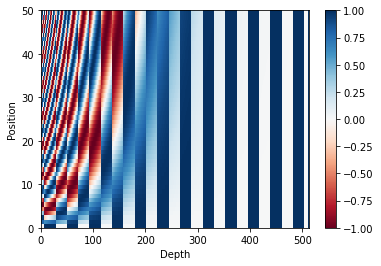

In [18]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## マスキング

シーケンスのバッチ中のパディングされた全てのトークンをマスクします。これにより、モデルがパディングを確実に入力として扱わないようにします。マスクは、パディング値`0`の存在を示します。つまり、`0`の場所で`1`を出力し、それ以外の場所では`0`を出力します。

In [19]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # アテンション・ロジットにパディングを追加するため
  # さらに次元を追加する
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [20]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

シーケンス中の未来のトークンをマスクするため、 ルックアヘッド・マスクが使われています。言い換えると、このマスクはどのエントリーを使うべきではないかを示しています。

これは、3番めの単語を予測するために、1つ目と2つ目の単語だけが使われるということを意味しています。同じように4つ目の単語を予測するには、1つ目、2つ目と3つ目の単語だけが使用され、次も同様となります。

In [21]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [22]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## スケール済み内積アテンション

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Transformerで使われているアテンション関数は3つの入力；Q(query), K(key), V(value)を取ります。このアテンションの重みの計算に使われている式は下記の通りです。

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

内積アテンションは、深度の平方根をファクターとしてスケールされています。これは、深度が大きくなると、内積が非常に大きくなり、ソフトマックス関数の勾配を計算すると非常に小さな値しか返さなくなってしまうためです。

例えば、`Q`と`K`が平均0分散1だと思ってください。これらの行列積は、平均0分散は`dk`となります。したがって、（他の数字ではなく）*`dk`の平方根*をスケーリングに使うことで、`Q` と `K` の行列積においても平均 0 分散 1 となり、緩やかな勾配を持つソフトマックスが得られることが期待できるのです。

マスクには、（負の無限大に近い）-1e9が掛けられています。これは、マスクがQとKのスケール済み行列積と合計され、ソフトマックスの直前に適用されるからです。目的は、これらのセルをゼロにしてしまうことで、大きなマイナスの入力は、ゼロに近い出力となります。

In [23]:
def scaled_dot_product_attention(q, k, v, mask):
  """アテンションの重みの計算
  q, k, vは最初の次元が一致していること
  k, vは最後から2番めの次元が一致していること
  マスクは型（パディングかルックアヘッドか）によって異なるshapeを持つが、
  加算の際にブロードキャスト可能であること
  引数：
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: (..., seq_len_q, seq_len_k) にブロードキャスト可能な
          shapeを持つ浮動小数点テンソル。既定値はNone
  
  戻り値：
    出力、アテンションの重み
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # matmul_qkをスケール
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # マスクをスケール済みテンソルに加算
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax は最後の軸(seq_len_k)について
  # 合計が1となるように正規化
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

ソフトマックス正規化がKに対して行われるため、その値がQに割り当てる重要度を決めることになります。

出力は、アテンションの重みとV(value)ベクトルの積を表しています。これにより、注目したい単語がそのまま残され、それ以外の単語は破棄されます。

In [24]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [25]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# この`query`は2番目の`key`に割り付けられているので
# 2番めの`value`が返される
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [26]:
# このクエリは（3番目と 4番目の）繰り返しキーに割り付けられるので
# 関連した全ての値が平均される
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [27]:
# このクエリは最初と2番めのキーに等しく割り付けられるので
# それらの値が平均される
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


すべてのクエリをまとめます。

In [28]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## マルチヘッド・アテンション

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


マルチヘッド・アテンションは4つのパートから成っています。
* 線形レイヤーとマルチヘッドへの分割
* スケール済み内積アテンション
* マルチヘッドの結合
* 最終線形レイヤー


各マルチヘッド・アテンション・ブロックは3つの入力：Q(query), K(key), V(value)を取ります。
これらは、線形（Dense）レイヤーを通され、マルチヘッドに分割されます。

上記で定義した`scaled_dot_product_attention`は（効率のためにブロードキャストで）各ヘッドに適用されます。アテンション・ステップにおいては、適切なマスクを使用しなければなりません。その後、各ヘッドのアテンション出力は（`tf.transpose`と`tf.reshape`を使って）結合され、最後の`Dense`レイヤーに通されます。

単一のアテンション・ヘッドのかわりに、Q、K、およびVは複数のヘッドに分割されます。なぜなら、それによって、モデルが異なる表現空間の異なる位置の情報について、連携してアテンションを計算できるからです。また、分割後の各ヘッドの次元を小さくすることで、全体の計算コストを、すべての次元を持つ単一のアテンション・ヘッドを用いた場合と同一にできます。

In [29]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """最後の次元を(num_heads, depth)に分割。
    結果をshapeが(batch_size, num_heads, seq_len, depth)となるようにリシェイプする。
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

試しに、`MultiHeadAttention`レイヤーを作ってみましょう。シーケンス `y` の各位置において、`MultiHeadAttention` はシーケンスのすべての位置に対して8つのヘッドを用いてアテンションを計算し、各位置それぞれで同じ長さの新しいベクトルを返します。

In [30]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## ポイントワイズのフィードフォワード・ネットワーク

ポイントワイズのフィードフォワード・ネットワークは、2つの全結合層とそれをつなぐReLU活性化層からなります。

In [31]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [32]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## エンコーダーとデコーダー

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Transformerモデルは、標準の[アテンション付きシーケンス・トゥー・シーケンスモデル](nmt_with_attention.ipynb)と同じ一般的なパターンを踏襲します。

* 入力の文は、`N`層のエンコーダー・レイヤーを通り、シーケンス中の単語／トークンごとに出力を生成する。
* デコーダーは、エンコーダーの出力と自分自身の入力（セルフアテンション）に注目し、次の単語を予測する。

### エンコーダー・レイヤー

それぞれのエンコーダー・レイヤーは次のようなサブレイヤーから成っています。

1.  マルチヘッド・アテンション（パディング・マスク付き）
2.  ポイントワイズ・フィードフォワード・ネットワーク

サブレイヤーにはそれぞれ残差接続があり、その後にレイヤー正規化が続きます。残差接続は、深いネットワークでの勾配消失問題を回避するのに役立ちます。

それぞれのサブレイヤーの出力は`LayerNorm(x + Sublayer(x))`です。正規化は、（最後の）`d_model`軸に対して行われます。TransformerにはN層のエンコーダーがあります。

In [33]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [34]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### デコーダー・レイヤー

各デコーダー・レイヤーは次のようなサブレイヤーからなります。

1. マスク付きマルチヘッド・アテンション（ ルックアヘッド・マスクおよびパディング・マスク付き）
2. （パディング・マスク付き）マルチヘッド・アテンション。V(value) と K(key) は*エンコーダーの出力*を入力として受け取る。Q(query)は*マスク付きマルチヘッド・アテンション・サブレイヤー*の出力を受け取る。
3. ポイントワイズ・フィードフォワード・ネットワーク

各サブレイヤーは残差接続を持ち、その後にレイヤー正規化が続きます。各サブレイヤーの出力は`LayerNorm(x + Sublayer(x))`です。正規化は、（最後の）`d_model`軸に沿って行われます。

Transformerには、N層のデコーダー・レイヤーが存在します。

Qがデコーダーの最初のアテンション・ブロックの出力を受け取り、Kがエンコーダーの出力を受け取るとき、アテンションの重みは、デコーダーの入力の、エンコーダーの出力に対する重要度を表します。言い換えると、デコーダーは、エンコーダーの出力と自分自身の出力のセルフ・アテンションを見て、次の単語を予想します。上記の、スケール済み内積アテンションのセクションのデモを参照してください。

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [36]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### エンコーダー

`Encoder`は次のものからできています。

1.  入力の埋め込み
2.  位置エンコーディング
3.  N 層のエンコーダー・レイヤー

入力は埋め込み層を通り、位置エンコーディングと合算されます。この加算の出力がエンコーダー・レイヤーの入力です。エンコーダーの出力はデコーダーの入力になります。

In [37]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # 埋め込みと位置エンコーディングを合算する
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [38]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### デコーダー

`Decoder` は次のもとからできています。
 
1.   出力埋め込み
2.   位置エンコーディング
3.   N 層のデコーダー・レイヤー

ターゲットは埋め込みを通り、位置エンコーディングと加算されます。この加算の出力がデコーダーの入力になります。デコーダーの出力は、最後の線形レイヤーの入力となります。

In [39]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [40]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformerの作成

 Transformerは、エンコーダー、デコーダーと、最後の線形レイヤーからなります。デコーダーの出力は、線形レイヤーの入力であり、その出力が返されます。

In [41]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [42]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## ハイパーパラメーターの設定

このサンプルを小さく、比較的高速にするため、 *num_layers, d_model, and dff*の値は小さくされています。

Transformerのベースモデルで使われている値は*num_layers=6*, *d_model = 512*, *dff = 2048*です。 Transformerの他のバージョンについては、[論文](https://arxiv.org/abs/1706.03762)を参照してください。

Note: 下記の値を変更することで、さまざまなタスクでSoTA（訳注：State of The Art、その時点での最高性能）を達成したモデルが得られます。

In [43]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## オプティマイザー

[論文](https://arxiv.org/abs/1706.03762)の中の式に従って、カスタムの学習率スケジューラーを持った、Adamオプティマイザーを使用します。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [45]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

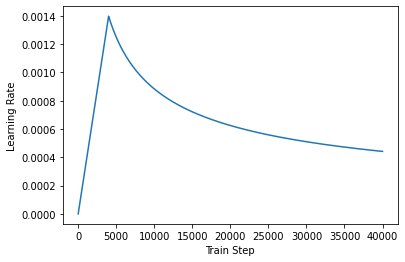

In [46]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 損失とメトリクス

ターゲットシーケンスはパディングされているため、損失を計算する際にパディング・マスクを適用することが重要です。

In [47]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [48]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [49]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 訓練とチェックポイント生成

In [50]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [51]:
def create_masks(inp, tar):
  # Encoderパディング・マスク
  enc_padding_mask = create_padding_mask(inp)
  
  # デコーダーの 2つ目のアテンション・ブロックで使用
  # このパディング・マスクはエンコーダーの出力をマスクするのに使用
  dec_padding_mask = create_padding_mask(inp)
  
  # デコーダーの 1つ目のアテンション・ブロックで使用
  # デコーダーが受け取った入力のパディングと将来のトークンをマスクするのに使用
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

チェックポイントのパスとチェックポイント・マネージャーを作成します。これは、`n`エポックごとにチェックポイントを保存するのに使用されます。

In [52]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# チェックポイントが存在したなら、最後のチェックポイントを復元
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

ターゲットは、tar_inpとtar_realに分けられます。tar_inpはデコーダーの入力として渡されます。`tar_real`は同じ入力を1つシフトしたものです。`tar_input`の位置それぞれで、`tar_real`は予測されるべき次のトークンを含んでいます。

たとえば、`sentence` = "SOS A lion in the jungle is sleeping EOS" だとすると、次のようになります。

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

Transformerは、自己回帰モデルです。1回に1箇所の予測を行い、その出力を次に何をすべきかの判断に使用します。

訓練時にこのサンプルは[テキスト生成チュートリアル](./text_generation.ipynb)のように、ティーチャーフォーシングを使用します。ティーチャーフォーシングとは、その時点においてモデルが何を予測したかに関わらず、真の出力を次のステップに渡すというものです。

Transformerが単語を予測するたびに、*セルフアテンション*のおかげで次の単語を予測するために入力シーケンスの過去の単語を参照することができます。

モデルが期待される出力を盗み見ることがないように、モデルはルックアヘッド・マスクを使用します。

In [53]:
EPOCHS = 20

In [54]:
# @tf.functionは高速に実行するためにtrain_stepをTFグラフにトレースコンパイルします。
# この関数は、引数となるテンソルのshapeに特化したものです。
# シーケンスの長さや（最後のバッチが小さくなるなど）バッチサイズが可変となることによって
# 再トレーシングが起きないようにするため、input_signatureを使って、より一般的なshapeを
# 指定します。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

ポルトガル語を入力言語とし、英語をターゲット言語とします。

In [55]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.9763 Accuracy 0.0004


Epoch 1 Batch 50 Loss 4.2042 Accuracy 0.0004


Epoch 1 Batch 100 Loss 4.1785 Accuracy 0.0109


Epoch 1 Batch 150 Loss 4.1183 Accuracy 0.0151


Epoch 1 Batch 200 Loss 4.0503 Accuracy 0.0172


Epoch 1 Batch 250 Loss 3.9723 Accuracy 0.0193


Epoch 1 Batch 300 Loss 3.8883 Accuracy 0.0241


Epoch 1 Batch 350 Loss 3.7982 Accuracy 0.0277


Epoch 1 Batch 400 Loss 3.7230 Accuracy 0.0306


Epoch 1 Batch 450 Loss 3.6471 Accuracy 0.0337


Epoch 1 Batch 500 Loss 3.5798 Accuracy 0.0366


Epoch 1 Batch 550 Loss 3.5230 Accuracy 0.0393


Epoch 1 Batch 600 Loss 3.4666 Accuracy 0.0427


Epoch 1 Batch 650 Loss 3.4099 Accuracy 0.0462


Epoch 1 Batch 700 Loss 3.3593 Accuracy 0.0497
Epoch 1 Loss 3.3583 Accuracy 0.0498
Time taken for 1 epoch: 53.75345039367676 secs

Epoch 2 Batch 0 Loss 2.7194 Accuracy 0.1103


Epoch 2 Batch 50 Loss 2.5624 Accuracy 0.1006


Epoch 2 Batch 100 Loss 2.5498 Accuracy 0.1042


Epoch 2 Batch 150 Loss 2.5284 Accuracy 0.1068


Epoch 2 Batch 200 Loss 2.5073 Accuracy 0.1095


Epoch 2 Batch 250 Loss 2.4913 Accuracy 0.1116


Epoch 2 Batch 300 Loss 2.4717 Accuracy 0.1136


Epoch 2 Batch 350 Loss 2.4595 Accuracy 0.1155


Epoch 2 Batch 400 Loss 2.4414 Accuracy 0.1169


Epoch 2 Batch 450 Loss 2.4266 Accuracy 0.1185


Epoch 2 Batch 500 Loss 2.4126 Accuracy 0.1202


Epoch 2 Batch 550 Loss 2.3988 Accuracy 0.1215


Epoch 2 Batch 600 Loss 2.3841 Accuracy 0.1230


Epoch 2 Batch 650 Loss 2.3705 Accuracy 0.1242


Epoch 2 Batch 700 Loss 2.3584 Accuracy 0.1254
Epoch 2 Loss 2.3572 Accuracy 0.1254
Time taken for 1 epoch: 29.322442531585693 secs

Epoch 3 Batch 0 Loss 1.8321 Accuracy 0.1443


Epoch 3 Batch 50 Loss 2.1570 Accuracy 0.1440


Epoch 3 Batch 100 Loss 2.1749 Accuracy 0.1448


Epoch 3 Batch 150 Loss 2.1589 Accuracy 0.1449


Epoch 3 Batch 200 Loss 2.1527 Accuracy 0.1462


Epoch 3 Batch 250 Loss 2.1488 Accuracy 0.1464


Epoch 3 Batch 300 Loss 2.1447 Accuracy 0.1466


Epoch 3 Batch 350 Loss 2.1401 Accuracy 0.1473


Epoch 3 Batch 400 Loss 2.1405 Accuracy 0.1480


Epoch 3 Batch 450 Loss 2.1322 Accuracy 0.1486


Epoch 3 Batch 500 Loss 2.1259 Accuracy 0.1493


Epoch 3 Batch 550 Loss 2.1182 Accuracy 0.1500


Epoch 3 Batch 600 Loss 2.1105 Accuracy 0.1506


Epoch 3 Batch 650 Loss 2.1020 Accuracy 0.1514


Epoch 3 Batch 700 Loss 2.0972 Accuracy 0.1524
Epoch 3 Loss 2.0967 Accuracy 0.1524
Time taken for 1 epoch: 29.156527519226074 secs

Epoch 4 Batch 0 Loss 1.8457 Accuracy 0.1516


Epoch 4 Batch 50 Loss 1.9508 Accuracy 0.1669


Epoch 4 Batch 100 Loss 1.9386 Accuracy 0.1676


Epoch 4 Batch 150 Loss 1.9383 Accuracy 0.1680


Epoch 4 Batch 200 Loss 1.9277 Accuracy 0.1686


Epoch 4 Batch 250 Loss 1.9303 Accuracy 0.1694


Epoch 4 Batch 300 Loss 1.9215 Accuracy 0.1703


Epoch 4 Batch 350 Loss 1.9135 Accuracy 0.1716


Epoch 4 Batch 400 Loss 1.9087 Accuracy 0.1725


Epoch 4 Batch 450 Loss 1.9019 Accuracy 0.1735


Epoch 4 Batch 500 Loss 1.8973 Accuracy 0.1748


Epoch 4 Batch 550 Loss 1.8924 Accuracy 0.1759


Epoch 4 Batch 600 Loss 1.8828 Accuracy 0.1769


Epoch 4 Batch 650 Loss 1.8757 Accuracy 0.1780


Epoch 4 Batch 700 Loss 1.8691 Accuracy 0.1790
Epoch 4 Loss 1.8693 Accuracy 0.1790
Time taken for 1 epoch: 29.42190384864807 secs

Epoch 5 Batch 0 Loss 1.6703 Accuracy 0.1807


Epoch 5 Batch 50 Loss 1.6796 Accuracy 0.1965


Epoch 5 Batch 100 Loss 1.6863 Accuracy 0.1986


Epoch 5 Batch 150 Loss 1.6882 Accuracy 0.1986


Epoch 5 Batch 200 Loss 1.6808 Accuracy 0.1985


Epoch 5 Batch 250 Loss 1.6790 Accuracy 0.1995


Epoch 5 Batch 300 Loss 1.6757 Accuracy 0.2001


Epoch 5 Batch 350 Loss 1.6752 Accuracy 0.2007


Epoch 5 Batch 400 Loss 1.6728 Accuracy 0.2017


Epoch 5 Batch 450 Loss 1.6639 Accuracy 0.2022


Epoch 5 Batch 500 Loss 1.6627 Accuracy 0.2031


Epoch 5 Batch 550 Loss 1.6573 Accuracy 0.2038


Epoch 5 Batch 600 Loss 1.6555 Accuracy 0.2045


Epoch 5 Batch 650 Loss 1.6488 Accuracy 0.2050


Epoch 5 Batch 700 Loss 1.6452 Accuracy 0.2057


Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Loss 1.6450 Accuracy 0.2056
Time taken for 1 epoch: 29.40642786026001 secs

Epoch 6 Batch 0 Loss 1.7069 Accuracy 0.2408


Epoch 6 Batch 50 Loss 1.4893 Accuracy 0.2178


Epoch 6 Batch 100 Loss 1.4910 Accuracy 0.2212


Epoch 6 Batch 150 Loss 1.4733 Accuracy 0.2212


Epoch 6 Batch 200 Loss 1.4792 Accuracy 0.2216


Epoch 6 Batch 250 Loss 1.4817 Accuracy 0.2219


Epoch 6 Batch 300 Loss 1.4797 Accuracy 0.2221


Epoch 6 Batch 350 Loss 1.4757 Accuracy 0.2226


Epoch 6 Batch 400 Loss 1.4757 Accuracy 0.2233


Epoch 6 Batch 450 Loss 1.4724 Accuracy 0.2236


Epoch 6 Batch 500 Loss 1.4715 Accuracy 0.2244


Epoch 6 Batch 550 Loss 1.4665 Accuracy 0.2250


Epoch 6 Batch 600 Loss 1.4639 Accuracy 0.2254


Epoch 6 Batch 650 Loss 1.4628 Accuracy 0.2258


Epoch 6 Batch 700 Loss 1.4603 Accuracy 0.2265
Epoch 6 Loss 1.4609 Accuracy 0.2265
Time taken for 1 epoch: 29.18768858909607 secs

Epoch 7 Batch 0 Loss 1.4019 Accuracy 0.2582


Epoch 7 Batch 50 Loss 1.3085 Accuracy 0.2423


Epoch 7 Batch 100 Loss 1.3084 Accuracy 0.2426


Epoch 7 Batch 150 Loss 1.2960 Accuracy 0.2420


Epoch 7 Batch 200 Loss 1.2971 Accuracy 0.2429


Epoch 7 Batch 250 Loss 1.2968 Accuracy 0.2435


Epoch 7 Batch 300 Loss 1.2934 Accuracy 0.2438


Epoch 7 Batch 350 Loss 1.2883 Accuracy 0.2443


Epoch 7 Batch 400 Loss 1.2885 Accuracy 0.2452


Epoch 7 Batch 450 Loss 1.2870 Accuracy 0.2458


Epoch 7 Batch 500 Loss 1.2870 Accuracy 0.2465


Epoch 7 Batch 550 Loss 1.2845 Accuracy 0.2467


Epoch 7 Batch 600 Loss 1.2826 Accuracy 0.2473


Epoch 7 Batch 650 Loss 1.2794 Accuracy 0.2475


Epoch 7 Batch 700 Loss 1.2761 Accuracy 0.2477
Epoch 7 Loss 1.2759 Accuracy 0.2477
Time taken for 1 epoch: 29.321438550949097 secs

Epoch 8 Batch 0 Loss 1.1444 Accuracy 0.2400


Epoch 8 Batch 50 Loss 1.1213 Accuracy 0.2639


Epoch 8 Batch 100 Loss 1.1158 Accuracy 0.2652


Epoch 8 Batch 150 Loss 1.1169 Accuracy 0.2652


Epoch 8 Batch 200 Loss 1.1204 Accuracy 0.2649


Epoch 8 Batch 250 Loss 1.1260 Accuracy 0.2659


Epoch 8 Batch 300 Loss 1.1238 Accuracy 0.2657


Epoch 8 Batch 350 Loss 1.1246 Accuracy 0.2661


Epoch 8 Batch 400 Loss 1.1249 Accuracy 0.2660


Epoch 8 Batch 450 Loss 1.1224 Accuracy 0.2663


Epoch 8 Batch 500 Loss 1.1219 Accuracy 0.2665


Epoch 8 Batch 550 Loss 1.1227 Accuracy 0.2666


Epoch 8 Batch 600 Loss 1.1223 Accuracy 0.2664


Epoch 8 Batch 650 Loss 1.1213 Accuracy 0.2664


Epoch 8 Batch 700 Loss 1.1212 Accuracy 0.2664
Epoch 8 Loss 1.1216 Accuracy 0.2664
Time taken for 1 epoch: 30.14285683631897 secs

Epoch 9 Batch 0 Loss 1.0180 Accuracy 0.2596


Epoch 9 Batch 50 Loss 0.9972 Accuracy 0.2831


Epoch 9 Batch 100 Loss 0.9969 Accuracy 0.2798


Epoch 9 Batch 150 Loss 0.9960 Accuracy 0.2794


Epoch 9 Batch 200 Loss 0.9926 Accuracy 0.2784


Epoch 9 Batch 250 Loss 0.9993 Accuracy 0.2781


Epoch 9 Batch 300 Loss 1.0051 Accuracy 0.2788


Epoch 9 Batch 350 Loss 1.0080 Accuracy 0.2791


Epoch 9 Batch 400 Loss 1.0099 Accuracy 0.2791


Epoch 9 Batch 450 Loss 1.0109 Accuracy 0.2792


Epoch 9 Batch 500 Loss 1.0119 Accuracy 0.2799


Epoch 9 Batch 550 Loss 1.0118 Accuracy 0.2801


Epoch 9 Batch 600 Loss 1.0129 Accuracy 0.2801


Epoch 9 Batch 650 Loss 1.0123 Accuracy 0.2800


Epoch 9 Batch 700 Loss 1.0124 Accuracy 0.2800
Epoch 9 Loss 1.0125 Accuracy 0.2800
Time taken for 1 epoch: 29.498162508010864 secs

Epoch 10 Batch 0 Loss 0.9420 Accuracy 0.3187


Epoch 10 Batch 50 Loss 0.9032 Accuracy 0.2905


Epoch 10 Batch 100 Loss 0.9000 Accuracy 0.2914


Epoch 10 Batch 150 Loss 0.8959 Accuracy 0.2910


Epoch 10 Batch 200 Loss 0.9045 Accuracy 0.2902


Epoch 10 Batch 250 Loss 0.9068 Accuracy 0.2894


Epoch 10 Batch 300 Loss 0.9140 Accuracy 0.2894


Epoch 10 Batch 350 Loss 0.9173 Accuracy 0.2893


Epoch 10 Batch 400 Loss 0.9174 Accuracy 0.2895


Epoch 10 Batch 450 Loss 0.9203 Accuracy 0.2900


Epoch 10 Batch 500 Loss 0.9214 Accuracy 0.2897


Epoch 10 Batch 550 Loss 0.9228 Accuracy 0.2895


Epoch 10 Batch 600 Loss 0.9256 Accuracy 0.2897


Epoch 10 Batch 650 Loss 0.9278 Accuracy 0.2899


Epoch 10 Batch 700 Loss 0.9289 Accuracy 0.2899


Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Epoch 10 Loss 0.9291 Accuracy 0.2899
Time taken for 1 epoch: 29.46539831161499 secs

Epoch 11 Batch 0 Loss 0.8609 Accuracy 0.3167


Epoch 11 Batch 50 Loss 0.8434 Accuracy 0.3105


Epoch 11 Batch 100 Loss 0.8401 Accuracy 0.3062


Epoch 11 Batch 150 Loss 0.8461 Accuracy 0.3049


Epoch 11 Batch 200 Loss 0.8528 Accuracy 0.3044


Epoch 11 Batch 250 Loss 0.8544 Accuracy 0.3028


Epoch 11 Batch 300 Loss 0.8550 Accuracy 0.3024


Epoch 11 Batch 350 Loss 0.8559 Accuracy 0.3019


Epoch 11 Batch 400 Loss 0.8573 Accuracy 0.3018


Epoch 11 Batch 450 Loss 0.8586 Accuracy 0.3014


Epoch 11 Batch 500 Loss 0.8617 Accuracy 0.3013


Epoch 11 Batch 550 Loss 0.8622 Accuracy 0.3011


Epoch 11 Batch 600 Loss 0.8646 Accuracy 0.3010


Epoch 11 Batch 650 Loss 0.8645 Accuracy 0.3006


Epoch 11 Batch 700 Loss 0.8651 Accuracy 0.3003
Epoch 11 Loss 0.8647 Accuracy 0.3003
Time taken for 1 epoch: 29.045116424560547 secs

Epoch 12 Batch 0 Loss 0.7635 Accuracy 0.2889


Epoch 12 Batch 50 Loss 0.7812 Accuracy 0.3140


Epoch 12 Batch 100 Loss 0.7805 Accuracy 0.3093


Epoch 12 Batch 150 Loss 0.7787 Accuracy 0.3093


Epoch 12 Batch 200 Loss 0.7858 Accuracy 0.3093


Epoch 12 Batch 250 Loss 0.7880 Accuracy 0.3089


Epoch 12 Batch 300 Loss 0.7942 Accuracy 0.3091


Epoch 12 Batch 350 Loss 0.7958 Accuracy 0.3088


Epoch 12 Batch 400 Loss 0.7956 Accuracy 0.3087


Epoch 12 Batch 450 Loss 0.7977 Accuracy 0.3088


Epoch 12 Batch 500 Loss 0.7998 Accuracy 0.3084


Epoch 12 Batch 550 Loss 0.8012 Accuracy 0.3085


Epoch 12 Batch 600 Loss 0.8036 Accuracy 0.3085


Epoch 12 Batch 650 Loss 0.8058 Accuracy 0.3081


Epoch 12 Batch 700 Loss 0.8074 Accuracy 0.3078
Epoch 12 Loss 0.8076 Accuracy 0.3078
Time taken for 1 epoch: 29.27844476699829 secs

Epoch 13 Batch 0 Loss 0.7942 Accuracy 0.3220


Epoch 13 Batch 50 Loss 0.7224 Accuracy 0.3186


Epoch 13 Batch 100 Loss 0.7226 Accuracy 0.3185


Epoch 13 Batch 150 Loss 0.7299 Accuracy 0.3175


Epoch 13 Batch 200 Loss 0.7354 Accuracy 0.3161


Epoch 13 Batch 250 Loss 0.7360 Accuracy 0.3156


Epoch 13 Batch 300 Loss 0.7381 Accuracy 0.3155


Epoch 13 Batch 350 Loss 0.7421 Accuracy 0.3153


Epoch 13 Batch 400 Loss 0.7450 Accuracy 0.3153


Epoch 13 Batch 450 Loss 0.7479 Accuracy 0.3154


Epoch 13 Batch 500 Loss 0.7505 Accuracy 0.3152


Epoch 13 Batch 550 Loss 0.7527 Accuracy 0.3149


Epoch 13 Batch 600 Loss 0.7559 Accuracy 0.3146


Epoch 13 Batch 650 Loss 0.7576 Accuracy 0.3142


Epoch 13 Batch 700 Loss 0.7602 Accuracy 0.3137
Epoch 13 Loss 0.7604 Accuracy 0.3136
Time taken for 1 epoch: 29.11438822746277 secs

Epoch 14 Batch 0 Loss 0.8321 Accuracy 0.3559


Epoch 14 Batch 50 Loss 0.6847 Accuracy 0.3258


Epoch 14 Batch 100 Loss 0.6878 Accuracy 0.3251


Epoch 14 Batch 150 Loss 0.6942 Accuracy 0.3256


Epoch 14 Batch 200 Loss 0.6947 Accuracy 0.3245


Epoch 14 Batch 250 Loss 0.6987 Accuracy 0.3231


Epoch 14 Batch 300 Loss 0.6997 Accuracy 0.3224


Epoch 14 Batch 350 Loss 0.7020 Accuracy 0.3222


Epoch 14 Batch 400 Loss 0.7026 Accuracy 0.3215


Epoch 14 Batch 450 Loss 0.7046 Accuracy 0.3210


Epoch 14 Batch 500 Loss 0.7087 Accuracy 0.3203


Epoch 14 Batch 550 Loss 0.7098 Accuracy 0.3197


Epoch 14 Batch 600 Loss 0.7121 Accuracy 0.3191


Epoch 14 Batch 650 Loss 0.7154 Accuracy 0.3188


Epoch 14 Batch 700 Loss 0.7180 Accuracy 0.3188
Epoch 14 Loss 0.7180 Accuracy 0.3187
Time taken for 1 epoch: 29.116370916366577 secs

Epoch 15 Batch 0 Loss 0.6012 Accuracy 0.3487


Epoch 15 Batch 50 Loss 0.6475 Accuracy 0.3284


Epoch 15 Batch 100 Loss 0.6577 Accuracy 0.3306


Epoch 15 Batch 150 Loss 0.6604 Accuracy 0.3298


Epoch 15 Batch 200 Loss 0.6608 Accuracy 0.3272


Epoch 15 Batch 250 Loss 0.6634 Accuracy 0.3261


Epoch 15 Batch 300 Loss 0.6690 Accuracy 0.3266


Epoch 15 Batch 350 Loss 0.6679 Accuracy 0.3259


Epoch 15 Batch 400 Loss 0.6696 Accuracy 0.3258


Epoch 15 Batch 450 Loss 0.6711 Accuracy 0.3257


Epoch 15 Batch 500 Loss 0.6732 Accuracy 0.3255


Epoch 15 Batch 550 Loss 0.6766 Accuracy 0.3252


Epoch 15 Batch 600 Loss 0.6804 Accuracy 0.3250


Epoch 15 Batch 650 Loss 0.6819 Accuracy 0.3249


Epoch 15 Batch 700 Loss 0.6847 Accuracy 0.3250


Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Epoch 15 Loss 0.6851 Accuracy 0.3251
Time taken for 1 epoch: 29.546141624450684 secs

Epoch 16 Batch 0 Loss 0.6150 Accuracy 0.3113


Epoch 16 Batch 50 Loss 0.6127 Accuracy 0.3317


Epoch 16 Batch 100 Loss 0.6157 Accuracy 0.3331


Epoch 16 Batch 150 Loss 0.6178 Accuracy 0.3328


Epoch 16 Batch 200 Loss 0.6254 Accuracy 0.3343


Epoch 16 Batch 250 Loss 0.6261 Accuracy 0.3323


Epoch 16 Batch 300 Loss 0.6278 Accuracy 0.3312


Epoch 16 Batch 350 Loss 0.6314 Accuracy 0.3311


Epoch 16 Batch 400 Loss 0.6325 Accuracy 0.3309


Epoch 16 Batch 450 Loss 0.6369 Accuracy 0.3306


Epoch 16 Batch 500 Loss 0.6400 Accuracy 0.3301


Epoch 16 Batch 550 Loss 0.6431 Accuracy 0.3295


Epoch 16 Batch 600 Loss 0.6461 Accuracy 0.3295


Epoch 16 Batch 650 Loss 0.6476 Accuracy 0.3290


Epoch 16 Batch 700 Loss 0.6510 Accuracy 0.3288
Epoch 16 Loss 0.6509 Accuracy 0.3288
Time taken for 1 epoch: 29.239344358444214 secs

Epoch 17 Batch 0 Loss 0.5796 Accuracy 0.3602


Epoch 17 Batch 50 Loss 0.5773 Accuracy 0.3379


Epoch 17 Batch 100 Loss 0.5874 Accuracy 0.3382


Epoch 17 Batch 150 Loss 0.5934 Accuracy 0.3389


Epoch 17 Batch 200 Loss 0.6007 Accuracy 0.3375


Epoch 17 Batch 250 Loss 0.6028 Accuracy 0.3373


Epoch 17 Batch 300 Loss 0.6037 Accuracy 0.3364


Epoch 17 Batch 350 Loss 0.6056 Accuracy 0.3361


Epoch 17 Batch 400 Loss 0.6064 Accuracy 0.3350


Epoch 17 Batch 450 Loss 0.6089 Accuracy 0.3346


Epoch 17 Batch 500 Loss 0.6124 Accuracy 0.3342


Epoch 17 Batch 550 Loss 0.6142 Accuracy 0.3337


Epoch 17 Batch 600 Loss 0.6173 Accuracy 0.3333


Epoch 17 Batch 650 Loss 0.6192 Accuracy 0.3327


Epoch 17 Batch 700 Loss 0.6224 Accuracy 0.3327
Epoch 17 Loss 0.6225 Accuracy 0.3327
Time taken for 1 epoch: 29.17945694923401 secs

Epoch 18 Batch 0 Loss 0.5471 Accuracy 0.3737


Epoch 18 Batch 50 Loss 0.5513 Accuracy 0.3403


Epoch 18 Batch 100 Loss 0.5633 Accuracy 0.3440


Epoch 18 Batch 150 Loss 0.5687 Accuracy 0.3440


Epoch 18 Batch 200 Loss 0.5733 Accuracy 0.3429


Epoch 18 Batch 250 Loss 0.5763 Accuracy 0.3419


Epoch 18 Batch 300 Loss 0.5770 Accuracy 0.3409


Epoch 18 Batch 350 Loss 0.5799 Accuracy 0.3408


Epoch 18 Batch 400 Loss 0.5818 Accuracy 0.3403


Epoch 18 Batch 450 Loss 0.5852 Accuracy 0.3398


Epoch 18 Batch 500 Loss 0.5880 Accuracy 0.3395


Epoch 18 Batch 550 Loss 0.5908 Accuracy 0.3387


Epoch 18 Batch 600 Loss 0.5940 Accuracy 0.3384


Epoch 18 Batch 650 Loss 0.5970 Accuracy 0.3383


Epoch 18 Batch 700 Loss 0.6000 Accuracy 0.3375
Epoch 18 Loss 0.6001 Accuracy 0.3375
Time taken for 1 epoch: 29.286636352539062 secs

Epoch 19 Batch 0 Loss 0.5206 Accuracy 0.3446


Epoch 19 Batch 50 Loss 0.5256 Accuracy 0.3441


Epoch 19 Batch 100 Loss 0.5295 Accuracy 0.3440


Epoch 19 Batch 150 Loss 0.5373 Accuracy 0.3435


Epoch 19 Batch 200 Loss 0.5442 Accuracy 0.3441


Epoch 19 Batch 250 Loss 0.5477 Accuracy 0.3445


Epoch 19 Batch 300 Loss 0.5511 Accuracy 0.3433


Epoch 19 Batch 350 Loss 0.5532 Accuracy 0.3430


Epoch 19 Batch 400 Loss 0.5557 Accuracy 0.3429


Epoch 19 Batch 450 Loss 0.5592 Accuracy 0.3423


Epoch 19 Batch 500 Loss 0.5639 Accuracy 0.3421


Epoch 19 Batch 550 Loss 0.5668 Accuracy 0.3419


Epoch 19 Batch 600 Loss 0.5696 Accuracy 0.3416


Epoch 19 Batch 650 Loss 0.5725 Accuracy 0.3409


Epoch 19 Batch 700 Loss 0.5756 Accuracy 0.3407
Epoch 19 Loss 0.5754 Accuracy 0.3406
Time taken for 1 epoch: 30.252567768096924 secs

Epoch 20 Batch 0 Loss 0.4838 Accuracy 0.3699


Epoch 20 Batch 50 Loss 0.5179 Accuracy 0.3539


Epoch 20 Batch 100 Loss 0.5189 Accuracy 0.3523


Epoch 20 Batch 150 Loss 0.5217 Accuracy 0.3514


Epoch 20 Batch 200 Loss 0.5237 Accuracy 0.3505


Epoch 20 Batch 250 Loss 0.5266 Accuracy 0.3486


Epoch 20 Batch 300 Loss 0.5297 Accuracy 0.3475


Epoch 20 Batch 350 Loss 0.5319 Accuracy 0.3468


Epoch 20 Batch 400 Loss 0.5362 Accuracy 0.3464


Epoch 20 Batch 450 Loss 0.5377 Accuracy 0.3463


Epoch 20 Batch 500 Loss 0.5413 Accuracy 0.3456


Epoch 20 Batch 550 Loss 0.5446 Accuracy 0.3455


Epoch 20 Batch 600 Loss 0.5475 Accuracy 0.3447


Epoch 20 Batch 650 Loss 0.5508 Accuracy 0.3442


Epoch 20 Batch 700 Loss 0.5541 Accuracy 0.3441


Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Epoch 20 Loss 0.5542 Accuracy 0.3441
Time taken for 1 epoch: 29.394241333007812 secs



## 評価

評価は次のようなステップで行われます。

* ポルトガル語のトークナイザー(`tokenizer_pt`)を使用して入力文をエンコードします。さらに、モデルの訓練に使用されたものと同様に、開始および終了トークンを追加します。これが、入力のエンコードです。
* デコーダーの入力は、`start token == tokenizer_en.vocab_size`です。
* パディング・マスクとルックアヘッド・マスクを計算します。
* `decoder`は、`encoder output`と自分自身の出力（セルフアテンション）を見て、予測値を出力します。
* 最後の単語を選択し、そのargmaxを計算します。
* デコーダーの入力に予測された単語を結合し、デコーダーに渡します。
* このアプローチでは、デコーダーは自分自身が予測した過去の単語にもとづいて次の単語を予測します。

Note: ここで使われているモデルは、より早く実行できるようにした能力の低いものであるため、予測はあまり正確ではありません。論文の結果を再現するには、データセット全体を使用し、上記のハイパーパラメーターを変更して、ベースのTransformerモデルまたはTransformer XLを使用します。

In [56]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp文はポルトガル語、開始および終了トークンを追加
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # ターゲットは英語であるため、Transformerに与える最初の単語は英語の
  # 開始トークンとなる
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # seq_len次元から最後の単語を選択
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # predicted_idが終了トークンと等しいなら結果を返す
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # 出力にpredicted_idを結合し、デコーダーへの入力とする
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [57]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # アテンションの重みをプロット
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [58]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [59]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to solve the us is to solve the united states that we need to solve a problem .
Real translation: this is a problem we have to solve .


In [60]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [61]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to be going to share with you some main stories of the magic things that happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


パラメータを`plot`するために、異なるレイヤーやデコーダーのアテンション・ブロックを渡すことができます。

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i did what i did was set .


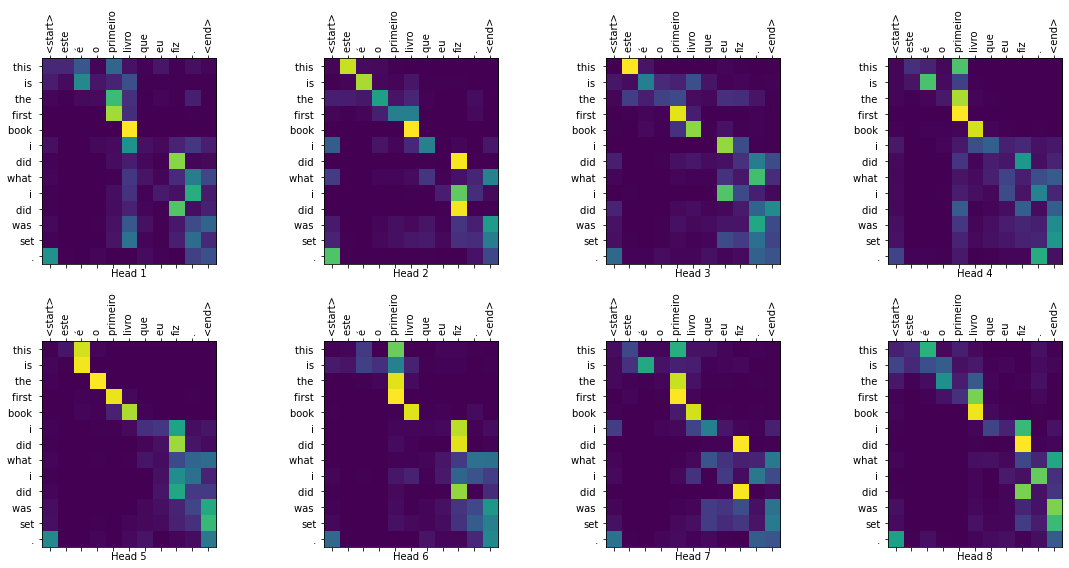

Real translation: this is the first book i've ever done.


In [62]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## まとめ

このチュートリアルでは、位置エンコーディング、マルチヘッド・アテンション、マスキングの重要性と、 Transformerの作成方法を学習しました。

Transformerを訓練するために、異なるデータセットを使ってみてください。また、上記のハイパーパラメーターを変更してベースTransformerやTransformer XLを構築することもできます。ここで定義したレイヤーを使って[BERT](https://arxiv.org/abs/1810.04805)を構築して、SoTAのモデルを作ることもできます。さらには、より良い予測を得るために、ビームサーチを組み込むこともできます。